In [66]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split,Dataset,Subset
import torchvision.transforms as transforms
import torchvision.models as models
from d2l import torch as d2l
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [67]:
# train = pd.read_csv('C:/Users/MJ/Desktop/FunctionApproximation/train.csv')
# test =pd.read_csv('C:/Users/MJ/Desktop/FunctionApproximation/test.csv')
# val_size = int(0.2 * len(train))
# train_size=len(train)-val_size
# train, valid = random_split(train,[train_size, val_size])

In [68]:
cuda = True if torch.cuda.is_available() else False

In [69]:
train=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/train.csv")
test=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/test.csv")
test_x=torch.tensor(test.drop(['id'],axis=1).values,dtype=torch.float32)

In [70]:
class FADataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.x=torch.tensor(data.drop(['id','y'],axis=1).values,dtype=torch.float32)
        self.y=torch.tensor(data['y'].values,dtype=torch.float32)
        self.flag=["F"]*len(self.x)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        data=self.x[idx]
        target=self.y[idx]
        return data,target,idx

    def update_flag(self, idx):
        self.flag[idx] = "T"
            

In [71]:
batch_size=80
dataset=FADataset(train)
trainset, validset = random_split(dataset, [0.9, 0.1])
train_dl= DataLoader(trainset, shuffle=True, batch_size=batch_size)
valid_dl= DataLoader(validset, shuffle=True, batch_size=batch_size)
test_dl=DataLoader(test_x,shuffle=False, batch_size=batch_size)


In [72]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_hidden1, num_hidden2,num_hidden3,num_hidden4,num_hidden5,num_hidden6, output_dim):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(input_dim,num_hidden1),
                                nn.ReLU(True),
                                nn.Linear(num_hidden1,num_hidden2),
                                nn.ReLU(True),
                                nn.Linear(num_hidden2,num_hidden3),
                                nn.ReLU(True),
                                nn.Linear(num_hidden3,num_hidden4),
                                nn.ReLU(True),  
                                nn.Linear(num_hidden4,num_hidden5),
                                nn.ReLU(True),  
                                nn.Linear(num_hidden5,num_hidden6),
                                nn.Linear(num_hidden6,output_dim)
                                )
    def forward(self, x):
        return self.model(x)


In [73]:
model=[]
optimizer=[]

for i in range(3):
    model.append(MLP(input_dim=2, num_hidden1=80,num_hidden2=128,num_hidden3=256,num_hidden4=512,num_hidden5=256,num_hidden6=128, output_dim=1))
    optimizer.append(torch.optim.Adam(model[i].parameters(), lr=0.0001))
criterion = nn.MSELoss()

In [74]:
num_epochs = 30
losses=[]
size = len(train_dl)
model[0].train()
for epoch in range(num_epochs):
    for batch,(data, target,idx) in enumerate(train_dl):
        outputs = model[0](data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        optimizer[0].zero_grad()
        loss.backward()
        optimizer[0].step()
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())


loss: 1.430140 
loss: 0.156024 
loss: 0.138100 
loss: 0.107474 
loss: 0.131290 
loss: 0.093947 
loss: 0.092248 
loss: 0.086461 
loss: 0.098303 
loss: 0.098729 
loss: 0.067815 
loss: 0.072668 
loss: 0.064067 
loss: 0.115648 
loss: 0.074427 
loss: 0.048258 
loss: 0.082293 
loss: 0.067706 
loss: 0.056780 
loss: 0.051836 
loss: 0.045116 
loss: 0.029589 
loss: 0.045536 
loss: 0.029413 
loss: 0.034377 
loss: 0.037046 
loss: 0.042528 
loss: 0.030160 
loss: 0.029014 
loss: 0.042294 
loss: 0.023863 
loss: 0.029627 
loss: 0.025498 
loss: 0.028202 
loss: 0.019009 
loss: 0.023598 
loss: 0.029320 
loss: 0.028273 
loss: 0.024797 
loss: 0.031352 
loss: 0.024938 
loss: 0.026069 
loss: 0.032231 
loss: 0.036813 
loss: 0.021668 
loss: 0.025228 
loss: 0.020586 
loss: 0.024699 
loss: 0.026758 
loss: 0.019334 
loss: 0.028905 
loss: 0.024609 
loss: 0.024346 
loss: 0.027277 
loss: 0.026452 
loss: 0.024277 
loss: 0.021715 
loss: 0.027861 
loss: 0.029227 
loss: 0.021122 


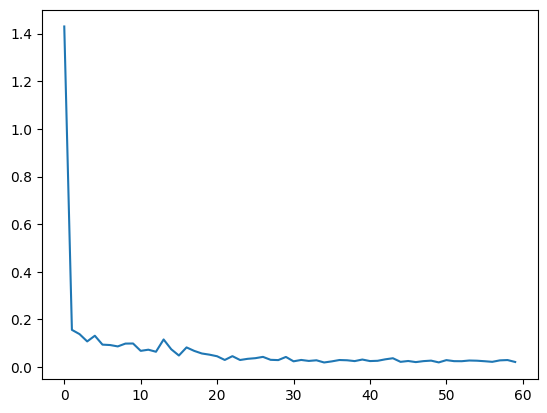

In [75]:
plt.plot(losses)

In [76]:
model[0].eval()

for batch,(data, target,idx) in enumerate(valid_dl):
    outputs = model[0](data)
    loss = criterion(outputs.reshape(-1), target.reshape(-1))
print(f"loss: {loss.item():>7f} ")

loss: 0.019536 


In [79]:
model[0].eval()
indexF=[]
indexT=[]
for i in range(len(trainset)):
    outputs = model[0](trainset.dataset.x[i])
    loss = criterion(outputs,trainset.dataset.y[i].reshape(1))
    if(loss>0.4):
        indexF.append(i)
    else:
        indexT.append(i)
        trainset.dataset.update_flag(i)

In [80]:
Fdataset=torch.utils.data.Subset(trainset, indexF)
Tdataset=torch.utils.data.Subset(trainset, indexT)
Fdl=DataLoader(Fdataset, shuffle=True, batch_size=batch_size)
Tdl=DataLoader(Tdataset, shuffle=True, batch_size=batch_size)


In [81]:
len(Fdl)

1

In [82]:
class Decision(nn.Module):
    def __init__(self, input_dim, num_hidden1, num_hidden2,num_hidden3, output_dim):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(input_dim,num_hidden1),
                                nn.Linear(num_hidden1,num_hidden2),
                                nn.Linear(num_hidden2,num_hidden3),
                                nn.Linear(num_hidden3,output_dim)
                                )
    def forward(self, x):
        return self.model(x)

In [83]:
model_decision=Decision(input_dim=2,num_hidden1=80,num_hidden2=128,num_hidden3=100,output_dim=2)
criterion_d = nn.CrossEntropyLoss()
optimizer_d= torch.optim.Adam(model_decision.parameters(), lr=0.001)

In [ ]:
class Newdata(Dataset):
    def __init__(self,x,y):
        super().__init__()
        self.x=x
        self.y=torch.LongTensor(LabelEncoder().fit_transform(y))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        data=self.x[idx]
        target=self.y[idx]
        return data,target


In [ ]:
decisionset=Newdata(trainset.dataset.x,trainset.dataset.flag)
decision_dl=DataLoader(decisionset, shuffle=True, batch_size=batch_size)

In [ ]:
#decision model train
num_epochs = 30
size = len(decision_dl)
model_decision.train()
for epoch in range(num_epochs):
    for batch,(data, target) in enumerate(decision_dl):
        outputs = model_decision(data)
        print(outputs)
        
        # loss = criterion_d(outputs, target)
        # optimizer_d.zero_grad()
        # loss.backward()
        # optimizer_d.step()
        # if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
        #     print(f"loss: {loss.item():>7f} ")
        #     losses.append(loss.item())

In [89]:
num_epochs = 50
size = len(Tdl)
model[1].train()
for epoch in range(num_epochs):
    for batch,(data, target,idx) in enumerate(Tdl):
        outputs = model[1](data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        optimizer[1].zero_grad()
        loss.backward()
        optimizer[1].step()
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())

loss: 0.016873 
loss: 0.024102 
loss: 0.021323 
loss: 0.022574 
loss: 0.020237 
loss: 0.028235 
loss: 0.021002 
loss: 0.021150 
loss: 0.024423 
loss: 0.018357 
loss: 0.025482 
loss: 0.020411 
loss: 0.030280 
loss: 0.019680 
loss: 0.026254 
loss: 0.029132 
loss: 0.020958 
loss: 0.023402 
loss: 0.021722 
loss: 0.024789 
loss: 0.021162 
loss: 0.024318 
loss: 0.021809 
loss: 0.023697 
loss: 0.019776 
loss: 0.018305 
loss: 0.018153 
loss: 0.029676 
loss: 0.026468 
loss: 0.021957 
loss: 0.022602 
loss: 0.025203 
loss: 0.028088 
loss: 0.027070 
loss: 0.021164 
loss: 0.026070 
loss: 0.019363 
loss: 0.024675 
loss: 0.023342 
loss: 0.018394 
loss: 0.024454 
loss: 0.026120 
loss: 0.016704 
loss: 0.025037 
loss: 0.024557 
loss: 0.020120 
loss: 0.015572 
loss: 0.023350 
loss: 0.019123 
loss: 0.024298 
loss: 0.025213 
loss: 0.014955 
loss: 0.018143 
loss: 0.029756 
loss: 0.027271 
loss: 0.022997 
loss: 0.019608 
loss: 0.021790 
loss: 0.023900 
loss: 0.024839 
loss: 0.027241 
loss: 0.021518 
loss: 0.

In [ ]:
num_epochs = 30
size = len(Fdl)
model[2].train()
for epoch in range(num_epochs):
    for batch,(data, target,idx) in enumerate(Fdl):
        outputs = model[2](data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        optimizer[2].zero_grad()
        loss.backward()
        optimizer[2].step()
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())

In [ ]:
plt.plot(losses)

In [ ]:
model[1].eval()

for batch,(data, target,idx) in enumerate(valid_dl):
    out = model_decision(data)
    print(out)
    # _, y_pred_tag = torch.max(out, dim = 1)


#     if(y_pred_tag==0):
#         outputs=model[1](data)
#     else:
#         outputs=model[2](data)
#     loss = criterion(outputs.reshape(-1), target.reshape(-1))
# print(f"loss: {loss.item():>7f} ")

In [ ]:
model[1].eval()

for batch,(data, target,idx) in enumerate(valid_dl):
    outputs = model[1](data)
    loss = criterion(outputs.reshape(-1), target.reshape(-1))
print(f"loss: {loss.item():>7f} ")

In [86]:
model[1].eval()
output=[]
for i in range(len(test_x)):
    output.append((model[1](test_x[i])).item())

In [87]:
min(output)

0.35943859815597534

In [88]:
sample_submission=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/sample_submission.csv")
sample_submission['y']=output
sample_submission.to_csv("C:/Users/MJ/Desktop/sample_submission.csv",index=False)